In [1]:


from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dython import nominal

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from permetrics.regression import Metrics

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet

from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

In [2]:
# Lead behandling and select relevant columns
behandling = pd.read_csv(Path('../20210324/with_name/behandling_optillfälle.csv'), sep=';')
behandling = behandling[['Der_Behandling_PK',
                         'Der_Opkort_FK',
                         'Der_Anestesikort_FK',
                         'Der_Vårdform_FK',
                         'Der_Prioritet_FK',
                         'BehandlingsStatus',
                         'ASAklass',
                         'ForberedelsetidStartTidpunkt',
                         'ForberedelsetidSlutTidpunkt',
                         'PatientÅlderVidOp',
                         'Veckodag',
                         'Starttimme',
                         'BMI',
                         'Kroppslängd',
                         'Kroppsvikt',
                         'OperationstidStart',
                         'AnestesitidStart'
                        ]]
behandling = behandling[behandling['BehandlingsStatus'] == 'Opererad'] # Remove 'abrutna' operationer as they do not contain all relevant data
print("Behandling length: {}".format(len(behandling)))

# Load ingrepp and select relevant columns
ingrepp = pd.read_csv(Path('../20210324/with_name/op_ingrepp_namn.csv'))
ingrepp = ingrepp[['Der_Behandling_PK',
                   'Ingreppkod',
                   'Primär_Sekundär',
                   'Sida',
                  ]]
ingrepp = ingrepp[ingrepp['Primär_Sekundär'] == 'Primär'] # Might want to include this if we make a more complicated model
print("Ingrepp length: {}".format(len(ingrepp)))

# Load diagnos and select relevant columns
diagnos = pd.read_csv(Path('../20210324/with_name/op_diagnos_namn.csv'))
diagnos = diagnos[['Der_Behandling_PK',
                   'Diagnoskod',
                   'Primär_Sekundär',
                  ]]
diagnos = diagnos[diagnos['Primär_Sekundär'] == 'Primär'] # Might want to include this if we make a more complicated model
print("Diagnos length: {}".format(len(diagnos)))

# Combine the data frames
combined_df = behandling.merge(diagnos, on='Der_Behandling_PK').merge(ingrepp, on='Der_Behandling_PK')
combined_df = combined_df.dropna()
print("Combined length: {}".format(len(combined_df)))

ingreppsgrupp = []
for index, row in combined_df.iterrows():
    ingrepp = row['Ingreppkod']
    ingrepp_group = ingrepp[0:2]
    ingreppsgrupp.append(ingrepp_group)
combined_df['IngreppsGrupp'] = ingreppsgrupp

diagnosgrupp = []
for index, row in combined_df.iterrows():
    diagnos = row['Diagnoskod']
    diagnos_grupp = diagnos[0]
    diagnosgrupp.append(diagnos_grupp)
combined_df['DiagnosGrupp'] = diagnosgrupp

# Calculate and add time to the dataframe
# Bad algoritm for checking min and max time of förbereds
start_pre = combined_df["ForberedelsetidStartTidpunkt"]
slut_pre = combined_df["ForberedelsetidSlutTidpunkt"]
start_an = combined_df['AnestesitidStart']
start_op = combined_df['OperationstidStart']

start_times = []
for time in start_pre:
    minn = int(time[-9:-7])
    hour = int(time[-12:-10])
    minutes = hour*60 + minn
    start_times.append(minutes)
    
stop_times = []
for time in slut_pre:
    minn = int(time[-9:-7])
    hour = int(time[-12:-10])
    minutes = hour*60 + minn
    stop_times.append(minutes)

an_times = []
for time in start_an:
    minn = int(time[-9:-7])
    hour = int(time[-12:-10])
    minutes = hour*60 + minn
    an_times.append(minutes)
    
op_times = []
for time in start_op:
    minn = int(time[-9:-7])
    hour = int(time[-12:-10])
    minutes = hour*60 + minn
    op_times.append(minutes)

times = []
for i in range(len(start_times)):
    #print(stop_times[i], start_times[i], stop_times[i] - start_times[i])
    times.append((stop_times[i] - start_times[i]) + (an_times[i] - op_times[i])) # Förberedelsetid + anestesiförberedelsetid
    
# Add total time to dataframe
combined_df['Tid'] = times

# Remove all fetuers we don't want
features_df = combined_df.drop(["Der_Behandling_PK", 
                               "Der_Opkort_FK",
                               "Der_Anestesikort_FK",
                               "BehandlingsStatus",
                               "ForberedelsetidStartTidpunkt",
                               "ForberedelsetidSlutTidpunkt",
                               "Primär_Sekundär_x",
                               "Primär_Sekundär_y",
                                "AnestesitidStart",
                                "OperationstidStart"
                            ], axis='columns')


'''
diagnosgrupper = {}
for diagnosgrupp, diagnosgrupp_df in features_df.groupby('DiagnosGrupp'):
    diagnosgrupper[diagnosgrupp] = diagnosgrupp_df
grupp_mean = []
grupp_std = []
for grupp in diagnosgrupper.keys():
    df = features_df[features_df['DiagnosGrupp'] == grupp]
    grupp_mean.append(df['time'].mean())
    grupp_std.append(df['time'].std())
#plt.errorbar(diagnosgrupper.keys(), grupp_mean, grupp_std, marker='o', linestyle='None', capsize=3)

ingreppsgrupper = {}
for ingreppsgrupp, ingreppsgrupp_df in features_df.groupby('IngreppsGrupp'):
    ingreppsgrupper[ingreppsgrupp] = ingreppsgrupp_df
grupp_mean = []
grupp_std = []
for grupp in ingreppsgrupper.keys():
    df = features_df[features_df['IngreppsGrupp'] == grupp]
    grupp_mean.append(df['time'].mean())
    grupp_std.append(df['time'].std())
#plt.errorbar(ingreppsgrupper.keys(), grupp_mean, grupp_std, marker='o', linestyle='None', capsize=3)
'''
features_df = features_df.drop(["Diagnoskod", "Ingreppkod"], axis='columns')
features_df = features_df[features_df['IngreppsGrupp'].isin(['NC', 'NH', 'NB', 'NG', 'NF', 'ND'])]

C:\Users\gidja1\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (80,81) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Behandling length: 4581
Ingrepp length: 4757
Diagnos length: 4582
Combined length: 3825


In [3]:
features_df = features_df.dropna()
for column in features_df.columns:
    print(column)

Der_Vårdform_FK
Der_Prioritet_FK
ASAklass
PatientÅlderVidOp
Veckodag
Starttimme
BMI
Kroppslängd
Kroppsvikt
Sida
IngreppsGrupp
DiagnosGrupp
Tid


In [4]:
NC_df = features_df[features_df['IngreppsGrupp'] == 'NC'].drop('IngreppsGrupp', axis=1)
NH_df = features_df[features_df['IngreppsGrupp'] == 'NH'].drop('IngreppsGrupp', axis=1)
NB_df = features_df[features_df['IngreppsGrupp'] == 'NB'].drop('IngreppsGrupp', axis=1)
NG_df = features_df[features_df['IngreppsGrupp'] == 'NG'].drop('IngreppsGrupp', axis=1)
NF_df = features_df[features_df['IngreppsGrupp'] == 'NF'].drop('IngreppsGrupp', axis=1)
ND_df = features_df[features_df['IngreppsGrupp'] == 'ND'].drop('IngreppsGrupp', axis=1)
ingreppsgrupper = {}
ingreppsgrupper['NC'] = NC_df
ingreppsgrupper['NH'] = NH_df
ingreppsgrupper['NB'] = NB_df
ingreppsgrupper['NG'] = NG_df
ingreppsgrupper['NF'] = NF_df
ingreppsgrupper['ND'] = ND_df

**Ingreppsgrupper**

<AxesSubplot:xlabel='IngreppsGrupp', ylabel='Tid'>

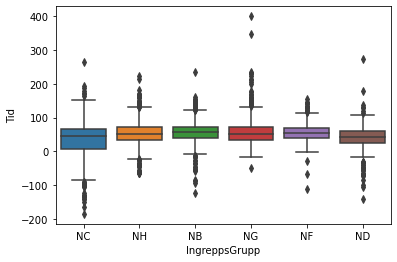

In [49]:
sns.boxplot(x=features_df['IngreppsGrupp'], y=features_df['Tid'])
# Setting the values for all axes.

**VÅRDFORM**

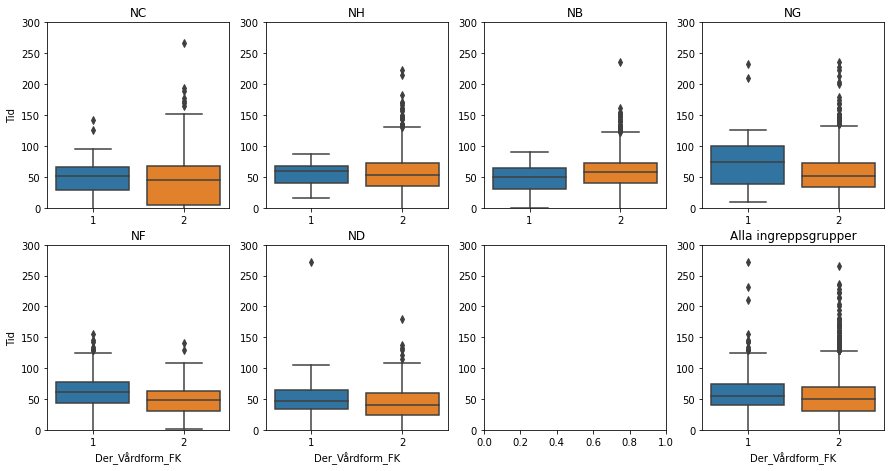

In [50]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7.5))
axes_index = 0
for ingreppsgrupp in ingreppsgrupper.keys():
    data_frame = pd.DataFrame(ingreppsgrupper[ingreppsgrupp])
    x = axes_index%4
    y = int(axes_index/4)
    axes[y][x].set_title(ingreppsgrupp)   
    sns.boxplot(x=data_frame['Der_Vårdform_FK'], y=data_frame['Tid'], ax=axes[y][x])
    axes_index += 1
    
axes[1][3].set_title("Alla ingreppsgrupper")   
sns.boxplot(x=features_df['Der_Vårdform_FK'], y=features_df['Tid'], ax=axes[1][3])

for axe in axes[0][:]:
    axe.set_xlabel('')
for axe in axes[0][1:]:
    axe.set_ylabel('')
for axe in axes[1][1:]:
    axe.set_ylabel('')
    
# Defining custom 'xlim' and 'ylim' values.
custom_ylim = (0, 300)

# Setting the values for all axes.
shit = plt.setp(axes, ylim=custom_ylim)


**Prioritet**

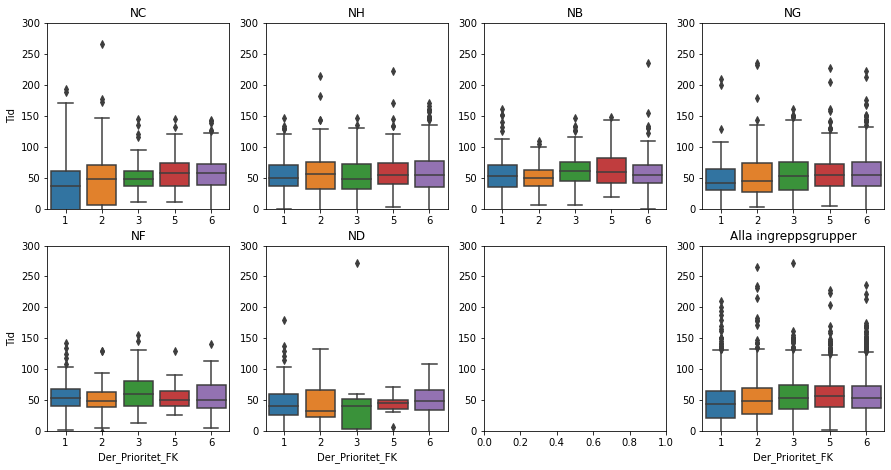

In [51]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7.5))
axes_index = 0
for ingreppsgrupp in ingreppsgrupper.keys():
    data_frame = pd.DataFrame(ingreppsgrupper[ingreppsgrupp])
    x = axes_index%4
    y = int(axes_index/4)
    axes[y][x].set_title(ingreppsgrupp)   
    sns.boxplot(x=data_frame['Der_Prioritet_FK'], y=data_frame['Tid'], ax=axes[y][x])
    axes_index += 1
    
axes[1][3].set_title("Alla ingreppsgrupper")   
sns.boxplot(x=features_df['Der_Prioritet_FK'], y=features_df['Tid'], ax=axes[1][3])

for axe in axes[0][:]:
    axe.set_xlabel('')
for axe in axes[0][1:]:
    axe.set_ylabel('')
for axe in axes[1][1:]:
    axe.set_ylabel('')
    
# Defining custom 'xlim' and 'ylim' values.
custom_ylim = (0, 300)

# Setting the values for all axes.
shit = plt.setp(axes, ylim=custom_ylim)

**ASAKlass**

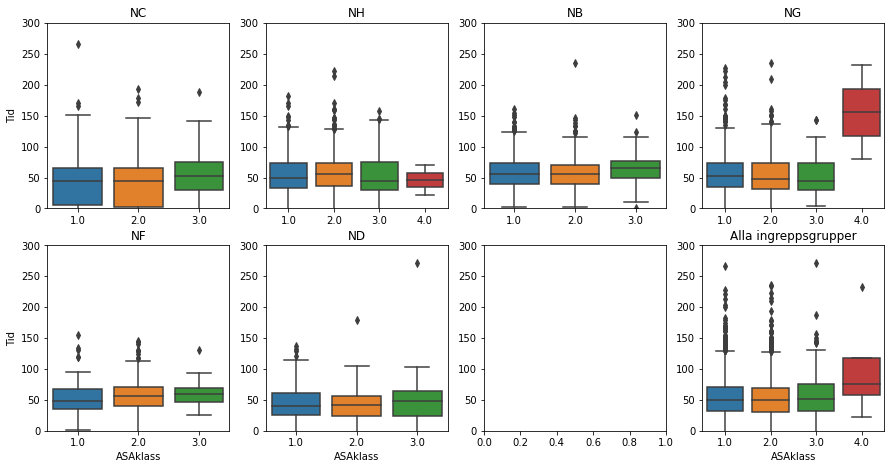

In [52]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7.5))
axes_index = 0
for ingreppsgrupp in ingreppsgrupper.keys():
    data_frame = pd.DataFrame(ingreppsgrupper[ingreppsgrupp])
    x = axes_index%4
    y = int(axes_index/4)
    axes[y][x].set_title(ingreppsgrupp)   
    sns.boxplot(x=data_frame['ASAklass'], y=data_frame['Tid'], ax=axes[y][x])
    axes_index += 1

axes[1][3].set_title("Alla ingreppsgrupper")   
sns.boxplot(x=features_df['ASAklass'], y=features_df['Tid'], ax=axes[1][3])
    
for axe in axes[0][:]:
    axe.set_xlabel('')
for axe in axes[0][1:]:
    axe.set_ylabel('')
for axe in axes[1][1:]:
    axe.set_ylabel('')
    
# Defining custom 'xlim' and 'ylim' values.
custom_ylim = (0, 300)

# Setting the values for all axes.
shit = plt.setp(axes, ylim=custom_ylim)

**PatientÅlderVidOp**

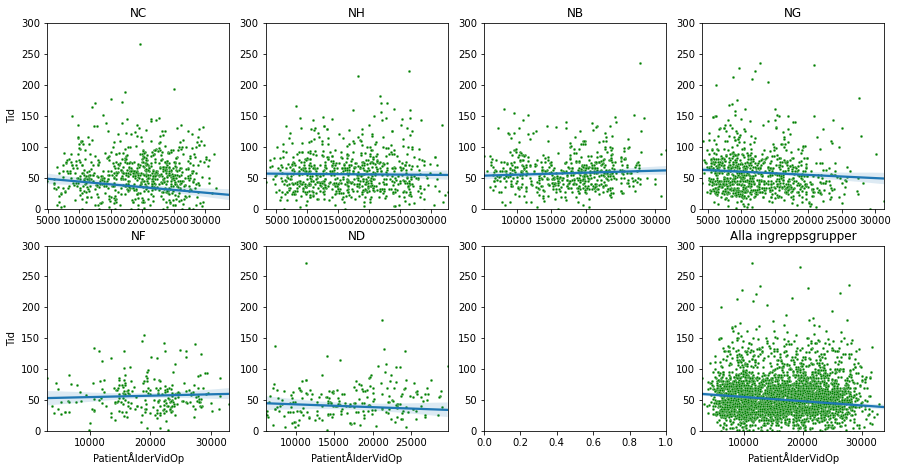

In [53]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7.5))
axes_index = 0
for ingreppsgrupp in ingreppsgrupper.keys():
    data_frame = pd.DataFrame(ingreppsgrupper[ingreppsgrupp])
    x = axes_index%4
    y = int(axes_index/4)
    axes[y][x].set_title(ingreppsgrupp)   
    sns.scatterplot(x=data_frame['PatientÅlderVidOp'], y=data_frame['Tid'], ax=axes[y][x], s=7, color='green')
    sns.regplot(x=data_frame['PatientÅlderVidOp'], y=data_frame['Tid'], ax=axes[y][x], scatter=False)
    axes_index += 1

axes[1][3].set_title("Alla ingreppsgrupper")   
sns.scatterplot(x=features_df['PatientÅlderVidOp'], y=features_df['Tid'], ax=axes[1][3], s=7, color='green')
sns.regplot(x=features_df['PatientÅlderVidOp'], y=features_df['Tid'], ax=axes[1][3], scatter=False)

for axe in axes[0][:]:
    axe.set_xlabel('')
for axe in axes[0][1:]:
    axe.set_ylabel('')
for axe in axes[1][1:]:
    axe.set_ylabel('')
    
# Defining custom 'xlim' and 'ylim' values.
custom_ylim = (0, 300)

# Setting the values for all axes.
shit = plt.setp(axes, ylim=custom_ylim)

**Starttimme**

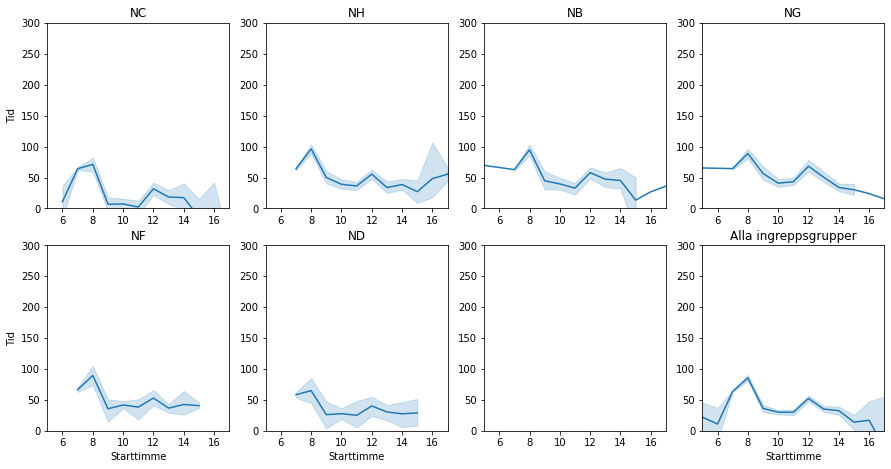

In [54]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7.5))
axes_index = 0
for ingreppsgrupp in ingreppsgrupper.keys():
    data_frame = pd.DataFrame(ingreppsgrupper[ingreppsgrupp])
    x = axes_index%4
    y = int(axes_index/4)
    axes[y][x].set_title(ingreppsgrupp)   
    #sns.boxplot(x=data_frame['Starttimme'], y=data_frame['time'], ax=axes[y][x])
    sns.lineplot(x=data_frame['Starttimme'], y=data_frame['Tid'], ax=axes[y][x])
    axes_index += 1
    
axes[1][3].set_title("Alla ingreppsgrupper")   
#sns.boxplot(x=features_df['Starttimme'], y=features_df['time'], ax=axes[1][3])
sns.lineplot(x=features_df['Starttimme'], y=features_df['Tid'], ax=axes[1][3])

for axe in axes[0][:]:
    axe.set_xlabel('')
for axe in axes[0][1:]:
    axe.set_ylabel('')
for axe in axes[1][1:]:
    axe.set_ylabel('')
    
# Defining custom 'xlim' and 'ylim' values.
custom_ylim = (0, 300)
custom_xlim = (5, 17)

# Setting the values for all axes.
shit = plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)

**BMI**

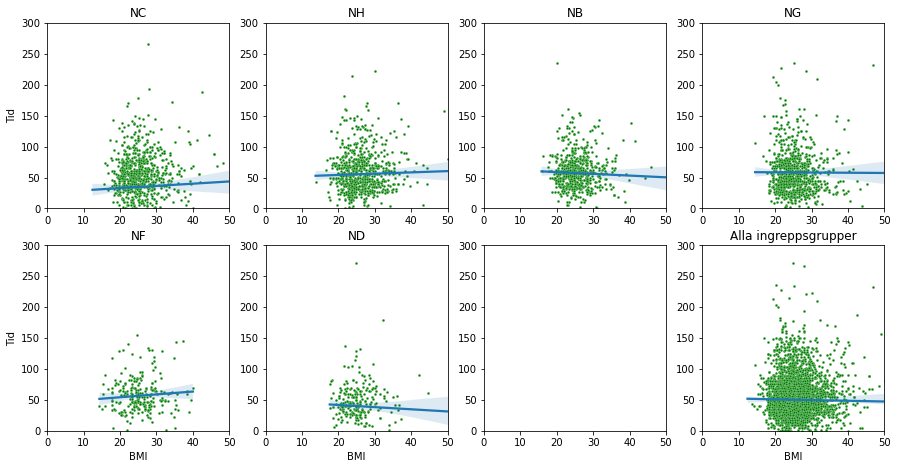

In [55]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7.5))
axes_index = 0
for ingreppsgrupp in ingreppsgrupper.keys():
    data_frame = pd.DataFrame(ingreppsgrupper[ingreppsgrupp])
    x = axes_index%4
    y = int(axes_index/4)
    axes[y][x].set_title(ingreppsgrupp)   
    sns.scatterplot(x=data_frame['BMI'], y=data_frame['Tid'], ax=axes[y][x], s=7, color='green')
    sns.regplot(x=data_frame['BMI'], y=data_frame['Tid'], ax=axes[y][x], scatter=False)
    axes_index += 1
    
axes[1][3].set_title("Alla ingreppsgrupper")   
sns.scatterplot(x=features_df['BMI'], y=features_df['Tid'], ax=axes[1][3], s=7, color='green')
sns.regplot(x=features_df['BMI'], y=features_df['Tid'], ax=axes[1][3], scatter=False)

for axe in axes[0][:]:
    axe.set_xlabel('')
for axe in axes[0][1:]:
    axe.set_ylabel('')
for axe in axes[1][1:]:
    axe.set_ylabel('')
    
# Defining custom 'xlim' and 'ylim' values.
custom_ylim = (0, 300)
custom_xlim = (0, 50)

# Setting the values for all axes.
shit = plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)

**Sida**

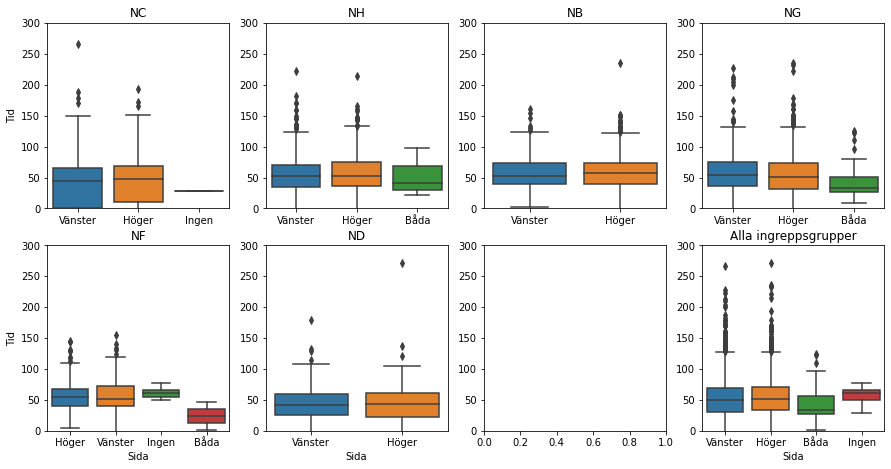

In [56]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7.5))
axes_index = 0
for ingreppsgrupp in ingreppsgrupper.keys():
    data_frame = pd.DataFrame(ingreppsgrupper[ingreppsgrupp])
    x = axes_index%4
    y = int(axes_index/4)
    axes[y][x].set_title(ingreppsgrupp)   
    sns.boxplot(x=data_frame['Sida'], y=data_frame['Tid'], ax=axes[y][x])
    #sns.lineplot(x=data_frame['Sida'], y=data_frame['time'], ax=axes[y][x])
    axes_index += 1
    
axes[1][3].set_title("Alla ingreppsgrupper")   
sns.boxplot(x=features_df['Sida'], y=features_df['Tid'], ax=axes[1][3])

for axe in axes[0][:]:
    axe.set_xlabel('')
for axe in axes[0][1:]:
    axe.set_ylabel('')
for axe in axes[1][1:]:
    axe.set_ylabel('')
    
# Defining custom 'xlim' and 'ylim' values.
custom_ylim = (0, 300)

# Setting the values for all axes.
shit = plt.setp(axes, ylim=custom_ylim)

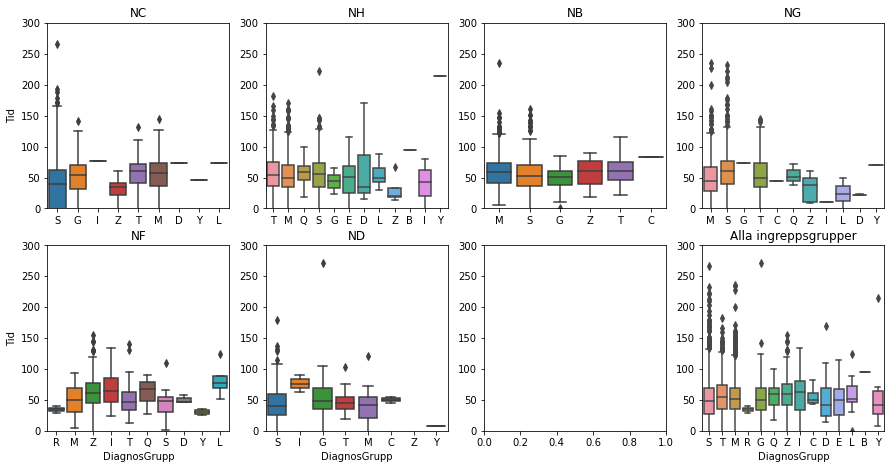

In [57]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7.5))
axes_index = 0
for ingreppsgrupp in ingreppsgrupper.keys():
    data_frame = pd.DataFrame(ingreppsgrupper[ingreppsgrupp])
    x = axes_index%4
    y = int(axes_index/4)
    axes[y][x].set_title(ingreppsgrupp)   
    sns.boxplot(x=data_frame['DiagnosGrupp'], y=data_frame['Tid'], ax=axes[y][x])
    #sns.lineplot(x=data_frame['Sida'], y=data_frame['time'], ax=axes[y][x])
    axes_index += 1

axes[1][3].set_title("Alla ingreppsgrupper")   
sns.boxplot(x=features_df['DiagnosGrupp'], y=features_df['Tid'], ax=axes[1][3])

for axe in axes[0][:]:
    axe.set_xlabel('')
for axe in axes[0][1:]:
    axe.set_ylabel('')
for axe in axes[1][1:]:
    axe.set_ylabel('')
    
# Defining custom 'xlim' and 'ylim' values.
custom_ylim = (0, 300)

# Setting the values for all axes.
shit = plt.setp(axes, ylim=custom_ylim)

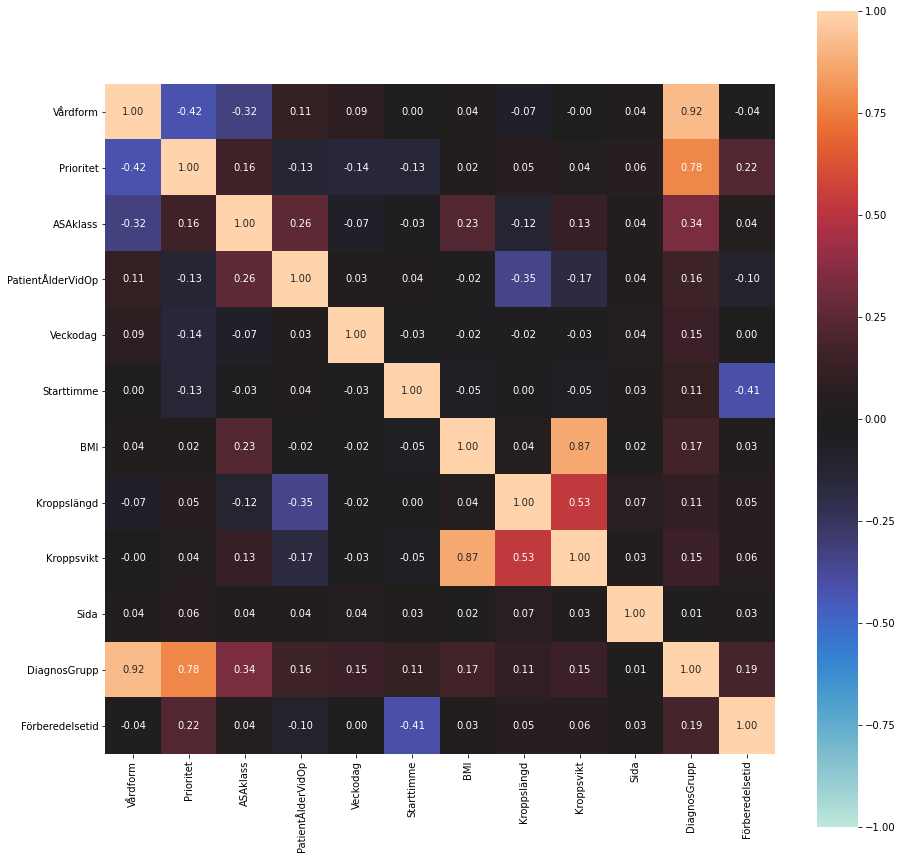

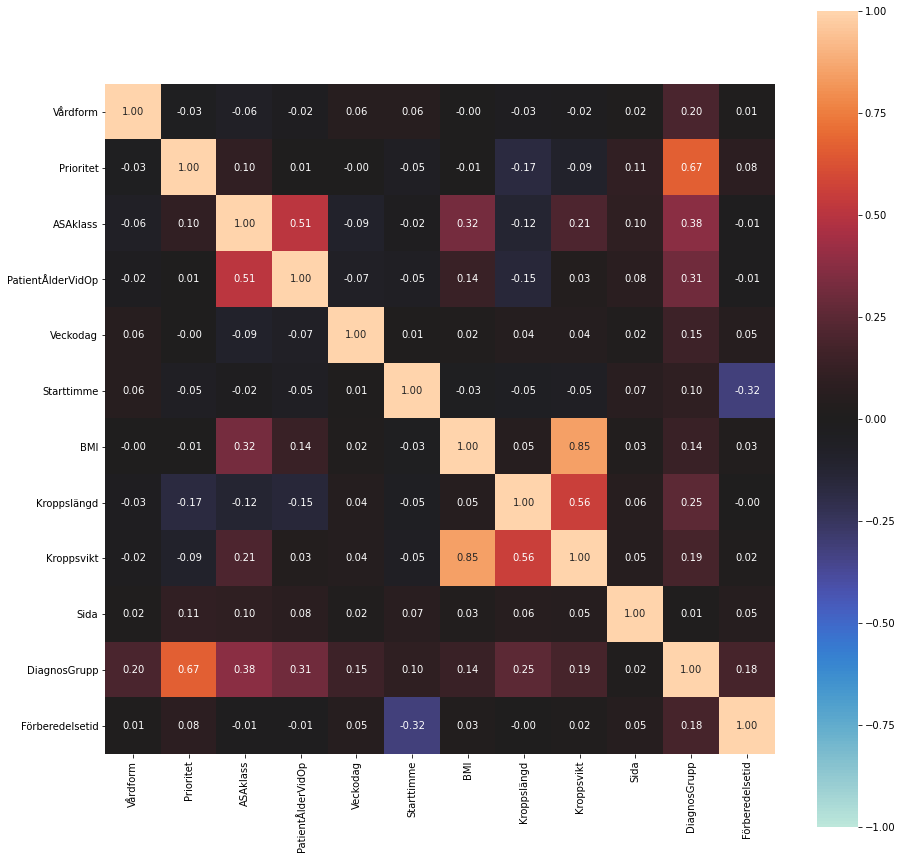

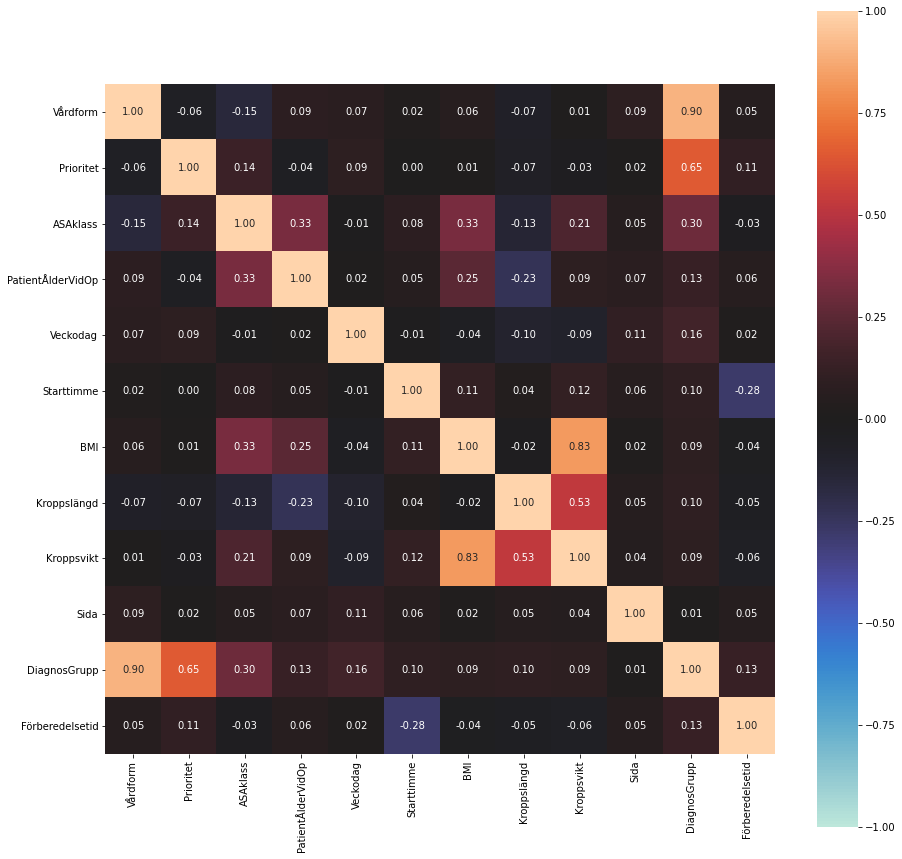

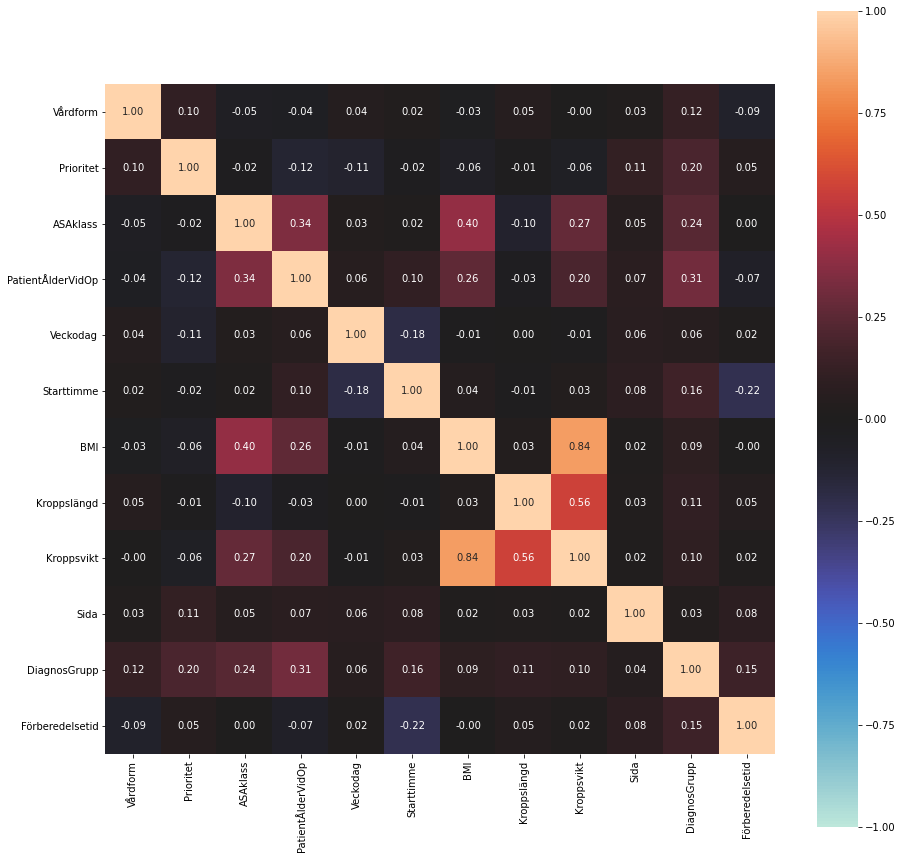

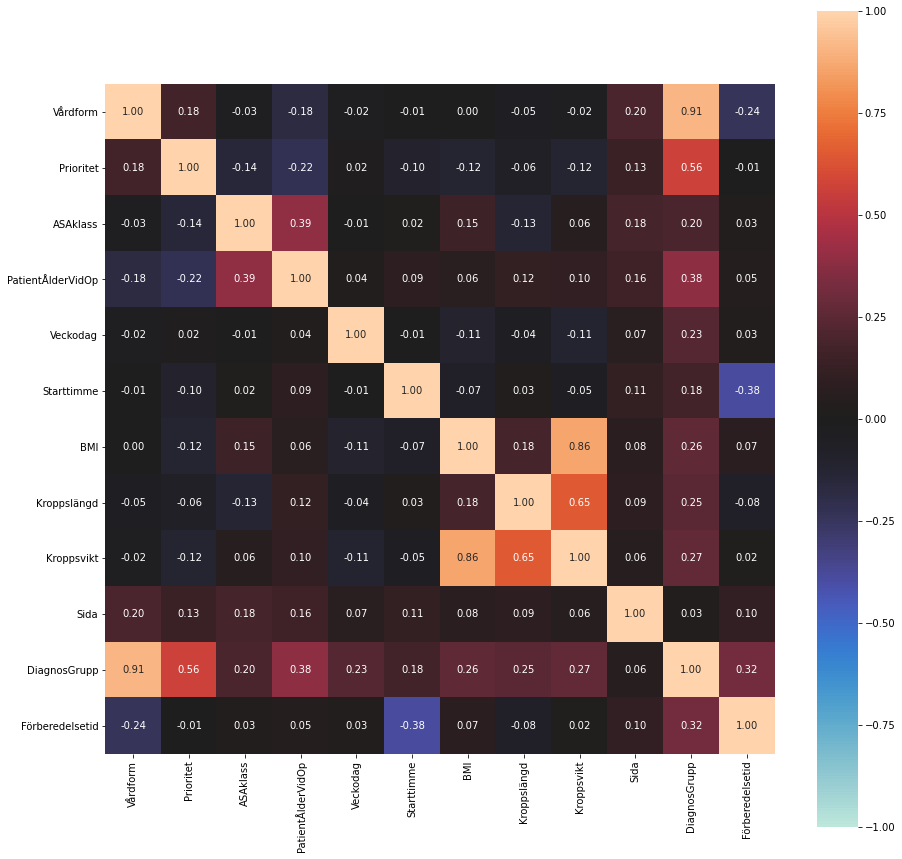

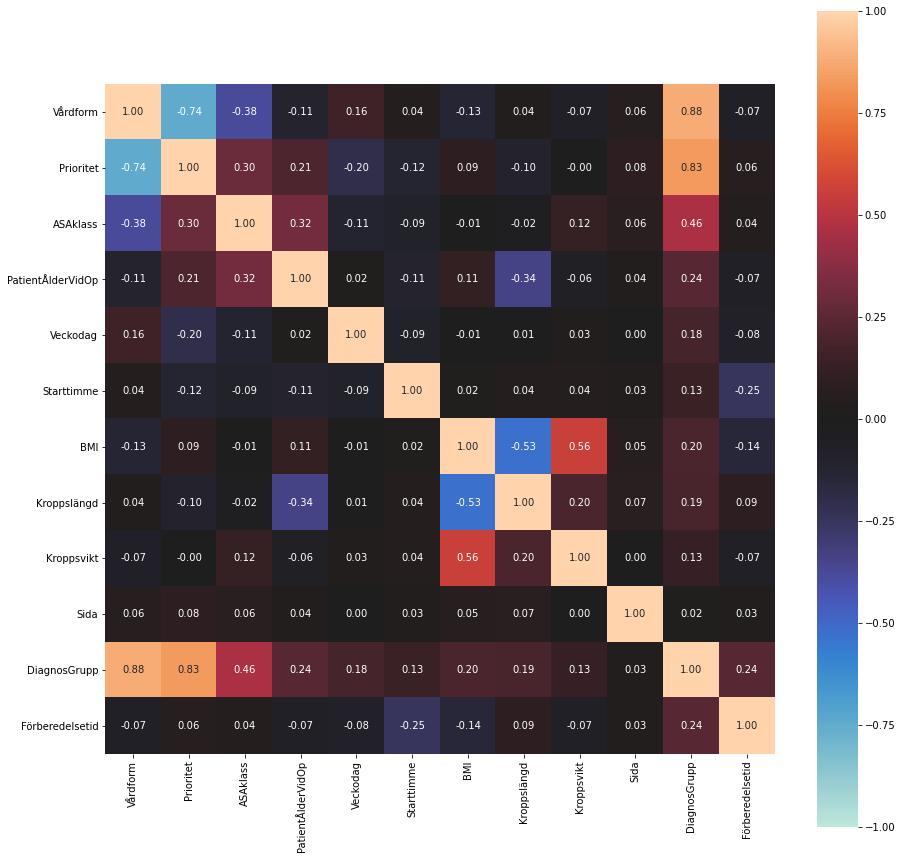

In [5]:
for ingreppsgrupp in ingreppsgrupper.keys():
    fig, ax = plt.subplots(figsize=(15, 15))
    data_frame = pd.DataFrame(ingreppsgrupper[ingreppsgrupp])
    data_frame = data_frame.rename(columns={'Der_Vårdform_FK':'Vårdform', 'Der_Prioritet_FK':'Prioritet', 'Tid':'Förberedelsetid'})
    nominal.associations(data_frame, nominal_columns=['Sida', 'DiagnosGrupp'], ax=ax, theil_u=True)
    fig.savefig(f'corr-matrix_{ingreppsgrupp}')
    plt.close()


### Gradient Boosting on indevidual shit

In [59]:
metrics = Metrics()

for ingreppsgrupp in ingreppsgrupper.keys():
    data_frame = ingreppsgrupper[ingreppsgrupp]
    y = data_frame['Tid']
    X = data_frame.drop('Tid', axis=1)
    X = pd.get_dummies(X)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=66)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state=66)
    
    boost_regr = GradientBoostingRegressor(max_depth=3,)
    boost_regr.fit(X_train, y_train)
    pred = boost_regr.predict(X_test)
    abs_error = mean_squared_error(y_test, pred, squared=False)
    percentage_error = metrics.mean_arctangent_absolute_percentage_error(clean=True, y_pred=np.array(pred), y_true=np.array(y_test))
    r2 = r2_score(y_test, pred)
    print(f'!{ingreppsgrupp}! \nabs error:{abs_error} \n% error: {percentage_error} \nR-squared: {r2} \n-----------------')

C:\Users\gidja1\Anaconda3\lib\site-packages\permetrics\regression.py:243: RuntimeWarning: divide by zero encountered in true_divide
  return round(mean(arctan(divide(abs(y_true - y_pred), y_true))), decimal)
C:\Users\gidja1\Anaconda3\lib\site-packages\permetrics\regression.py:243: RuntimeWarning: divide by zero encountered in true_divide
  return round(mean(arctan(divide(abs(y_true - y_pred), y_true))), decimal)


!NC! 
abs error:43.48030496206417 
% error: 0.198 
R-squared: 0.22991256261767135 
-----------------
!NH! 
abs error:31.20371484825815 
% error: 0.319 
R-squared: 0.22457044359026335 
-----------------
!NB! 
abs error:35.77874184707265 
% error: 0.245 
R-squared: 0.012482525000399591 
-----------------
!NG! 
abs error:36.647318350814686 
% error: 0.411 
R-squared: 0.16146045171405665 
-----------------
!NF! 
abs error:20.734938816838614 
% error: 0.307 
R-squared: 0.5387175479283546 
-----------------
!ND! 
abs error:40.363607305858054 
% error: 0.354 
R-squared: -0.1784053784321995 
-----------------
